# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

###### I was facing issues handling azdias dataset (timeout/ workspace is idle etc.). I decided to use sample azdias instead of  the complete dataset 

In [2]:
f = '../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv'
num_lines = sum(1 for l in open(f))

size = int(num_lines/2.5)
skip_idx = random.sample(range(1,num_lines),num_lines - size)
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',skiprows=skip_idx)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


One thing to notice after loading both azdias and customers dataset is columns 18 and 19 are of mixed types. Let's see which columns are column 18 and 19

In [4]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [5]:
azdias.CAMEO_DEUG_2015.value_counts()

8      35435
9      28442
6      27585
4      27401
3      22699
2      21893
7      20394
8.0    18330
9.0    14876
6.0    14612
5      14576
4.0    14215
3.0    12057
2.0    11427
7.0    10781
1       9335
5.0     7586
1.0     5012
X        172
Name: CAMEO_DEUG_2015, dtype: int64

In [6]:
azdias.CAMEO_INTL_2015.value_counts(0)

51      35144
41      24241
24      24035
51.0    18339
14      16529
43      14585
41.0    12698
24.0    12697
54      11933
25      10337
22       8661
14.0     8634
43.0     7831
23       7067
45       7010
13       6875
55       6303
54.0     6270
25.0     5440
52       5438
31       5012
34       4849
22.0     4513
15       4372
44       3849
23.0     3622
13.0     3599
45.0     3468
12       3452
55.0     3247
52.0     2839
32       2766
35       2710
33       2592
31.0     2589
34.0     2506
15.0     2342
44.0     2061
12.0     1864
35.0     1496
32.0     1447
33.0     1394
XX        172
Name: CAMEO_INTL_2015, dtype: int64

We need to replace X in CAMEO_DEUG_2015 and rows with value XX in CAMEO_INTL_2015 from both azdias and customers dataset. 

In [7]:
def mixed_feature_handler(df):
    '''
    This function deals with the special characters in the cameo columns
    Finds the special characters and replaces them with nan
    '''
    
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    df[cols] = df[cols].replace({'X': np.nan, 'XX':np.nan, '': np.nan, ' ':np.nan})
    df[cols] = df[cols].astype(float)
       
    return df

In [8]:
azdias = mixed_feature_handler(azdias)
customer = mixed_feature_handler(customers)

Also, notice in CAMEO_DEUG_2015 and CAMEO_DEUG_2015, 1 and 1.0 is same, as they represent the same class. I am going to deal with this situation after imputation

##### Getting some basic stats related to azdias dataset - like shape, mean, standard deviation, different percentiles

In [9]:
azdias.shape

(356487, 366)

In [10]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
2,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
3,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
4,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1


In [11]:
pd.set_option('display.max_rows', 500)
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,356487.0,637495.826319,257238.427036,191653.0,414739.5,637375.0,859953.5,1082872.0
AGER_TYP,356487.0,-0.356714,1.199410,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,327099.0,4.423211,3.639090,1.0,1.0,3.0,9.0,9.0
ALTER_HH,327099.0,10.857245,7.638925,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,32478.0,11.755896,4.098619,2.0,8.0,12.0,15.0,18.0
ALTER_KIND2,11825.0,13.407273,3.229476,2.0,11.0,14.0,16.0,18.0
ALTER_KIND3,2462.0,14.501219,2.707875,4.0,13.0,15.0,17.0,18.0
ALTER_KIND4,479.0,15.212944,2.271471,8.0,14.0,15.0,17.0,18.0
ALTERSKATEGORIE_FEIN,251268.0,13.694621,5.076622,0.0,11.0,14.0,17.0,25.0
ANZ_HAUSHALTE_AKTIV,319182.0,8.278738,15.471738,0.0,1.0,4.0,10.0,595.0


##### Getting some basic stats related to customers dataset - like shape, mean, standard deviation, different percentiles

In [12]:
customers.shape

(191652, 369)

In [13]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Next, I am reading description of these columns to get an idea what these attributes really means.

In [14]:
dias_information = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx')
dias_information.drop('Unnamed: 0', axis=1, inplace=True)
dias_information.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [15]:
dias_attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')
dias_attributes.drop('Unnamed: 0', axis=1, inplace=True)
dias_attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


It's not feasible to print out the whole attributes file, as it has ~2.3k rows. I will download the DIAS Attributes - Values 2017.xlsx file to see what different values means in different categories.

#### Convert missing value codes to NaN

I want to identify all the values which are unknown or contiain no in the meaning string. First, I will filter the dias_attribute data frame and using which the same data frame I will replace the missing value code with NaNs. 

In [16]:
dias_attributes['Attribute'] = dias_attributes['Attribute'].fillna(method='ffill')
dias_attributes = dias_attributes[(dias_attributes['Meaning'].str.contains("unknown") | dias_attributes['Meaning'].str.contains("no "))]
dias_attributes[290:]

,Attribute,Description,Value,Meaning
2194,SEMIO_VERT,affinity indicating in what way the person is ...,"-1, 9",unknown
2202,SHOPPER_TYP,shopping typology,-1,unknown
2207,SOHO_FLAG,small office/home office flag,-1,unknown
2208,SOHO_FLAG,NaN,0,no small office/home office
2210,TITEL_KZ,flag whether this person holds an academic title,"-1, 0",unknown
2216,VERS_TYP,insurance typology,-1,unknown
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2230,WOHNLAGE,NaN,0,no score calculated
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown


In [17]:
unknowns = []
features = []

for feature in dias_attributes['Attribute'].unique():
    missing_or_unknown = dias_attributes.loc[dias_attributes['Attribute'] == feature, 'Value'].astype(str).str.cat(sep=',').split(',')
    unknowns.append(missing_or_unknown)
    features.append(feature)
    
unknowns_df = pd.concat([pd.Series(features), pd.Series(unknowns)], axis=1)
unknowns_df.columns = ['attribute', 'missing_or_unknown']
unknowns_df.head()

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


### Replacing Nan's code with Nan values

In [18]:
def replacing_with_nan(df):
    for row in unknowns_df['attribute']:
        if row in azdias.columns:
            na_map = unknowns_df.loc[unknowns_df['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df.loc[:, row].isin(na_map)
            df.loc[na_idx, row] = np.NaN
        else:
            continue
            
    return df

Replacing unknown code values with NaN for both customers and azdias dataset.

In [19]:
customers = replacing_with_nan(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0


In [20]:
azdias = replacing_with_nan(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
2,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
3,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4.0,2.0,2.0
4,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0


As of now, I am preprocessing only azdias dataset. Later, I will create I will create a function to perform similar preprcessing on the customer dataset as well. 

### Deleting columns with null values

##### Handing Null Values and checking their distributions

First, let's see what is the distribution of null values accross the columns. I am going to create a dataframe to store the percentage of null values in columns.

In [21]:
def identify_columns_null_values(df):
    
    '''
    This function takes a dataframe as an input and resturn a list of all the columns where
    null values are more than 40% of the total values in the column
    '''

    df_null = df.isnull().sum()
    df_null_percent = df_null / len(df) * 100

    df_null_percent.sort_values()[330:].plot.barh(figsize=(10,10),fontsize=12,color='teal')
    print('columns having  missing values >40% : ',len(df_null_percent[df_null_percent>40].index))
    
    df_null_list = list(df_null_percent[df_null_percent>40].index)
    return df_null_list

columns having  missing values >40% :  37


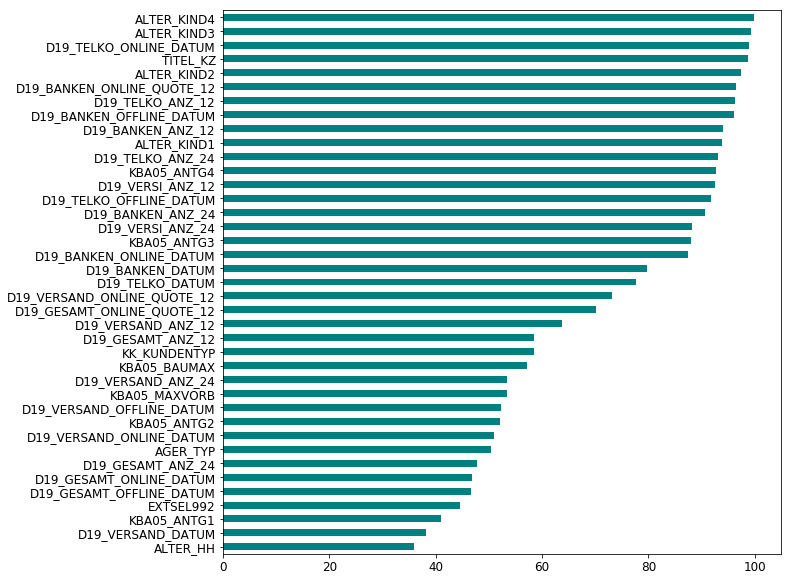

In [22]:
customers_null_list = identify_columns_null_values(customers)

columns having  missing values >40% :  37


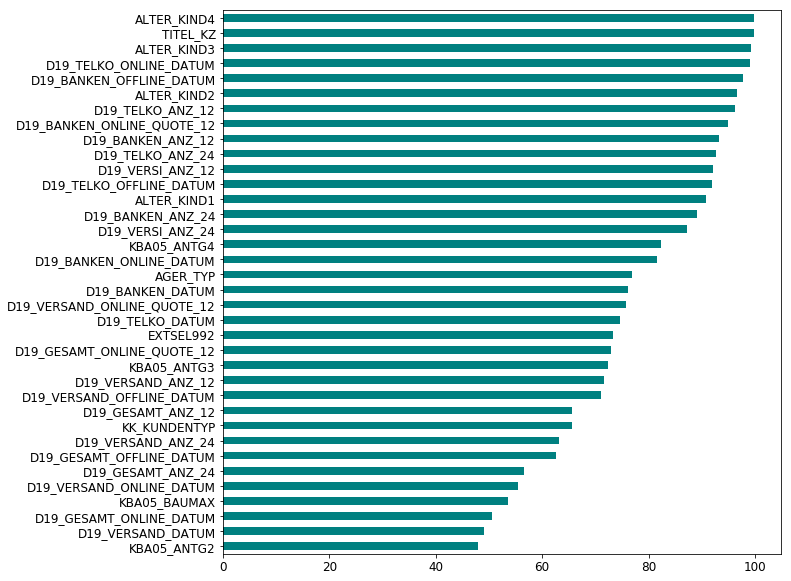

In [23]:
azdias_null_list = identify_columns_null_values(azdias)

In [24]:
len(list(set(customers_null_list) & set(azdias_null_list)))

36

There are 36 columns where 40% of the values are null are common in both azdias and customers dataset. 

In [25]:
len(list(set(customers_null_list) | set(azdias_null_list)))

38

However, to remain consistent we need to remove all 38 columns from both the dataset.

In [26]:
columns_to_drop = list(set(customers_null_list) | set(azdias_null_list))

In [27]:
azdias.drop(columns_to_drop, axis=1, inplace = True)
customers.drop(columns_to_drop, axis=1, inplace = True)

In [28]:
print(azdias.shape)
print(customers.shape)

(356487, 328)
(191652, 331)


### Removing rows with missing values

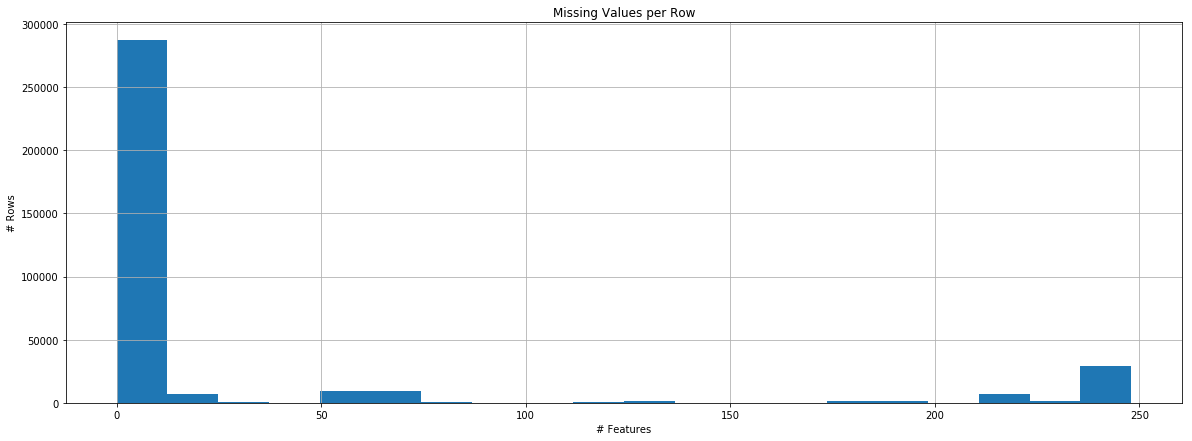

In [29]:
fig = plt.figure(figsize=(20,7))
azdias.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('# Features')
plt.ylabel('# Rows');

I'll use a threshold of 230 which means that rows that have more than 230 features missing will be dropped.

In [30]:
azdias_low_missing = azdias.dropna(thresh=230)
azdias_low_missing.shape

(314121, 328)

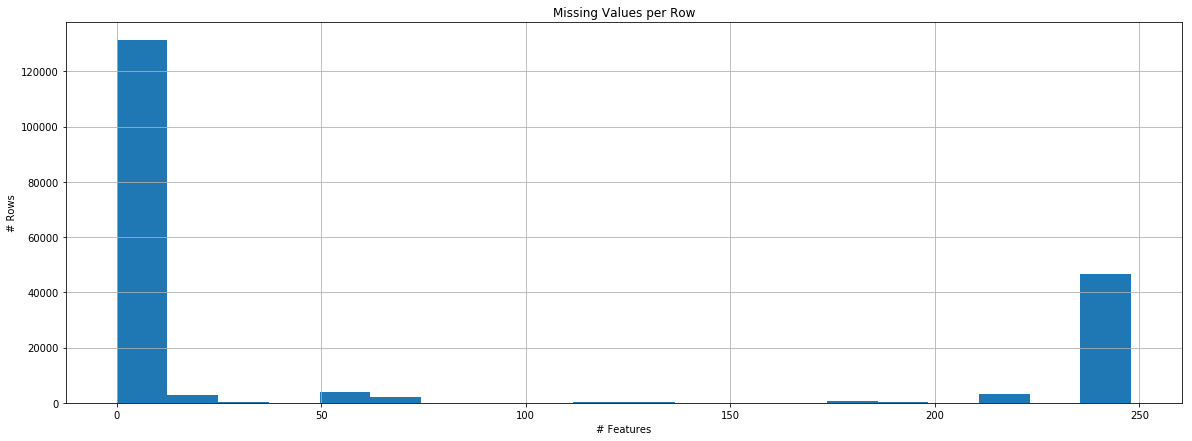

In [31]:
fig = plt.figure(figsize=(20,7))
customers.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('# Features')
plt.ylabel('# Rows');

In [32]:
customers_low_missing = customers.dropna(thresh=230)
customers_low_missing.shape

(140371, 331)

### Encode features with mixed value, i.e. column 18 and 19

### Removing rows with outlier values

Next, I will identify the columns with only two values so that I can convert them in binary columns.

In [33]:
categorical_binary=[]

for feature in azdias.columns:
    if azdias[feature].nunique() == 2:
        categorical_binary.append(feature)

In [34]:
categorical_binary

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ']

In [35]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [36]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [37]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
